<a href="https://colab.research.google.com/github/utkarsh027/Langgraph_ChatBot/blob/main/Langgraph_chatbot_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [72]:
from typing import Annotated
from typing_extensions import TypedDict


In [73]:
!pip install arxiv wikipedia

In [74]:
## Working with tools

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.llms import OpenAI

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv and Wikipedia tools

arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [75]:
wiki_tool.invoke("who is salman khan")

"Page: Salman Khan\nSummary: Abdul Rashid Salim Salman Khan (pronounced [səlˈmɑːn xɑːn]; born 27 December 1965) is an Indian actor, film producer, and television personality who predominantly works in Hindi films. In a career spanning over three decades, Khan's awards, include two National Film Awards"

In [76]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [77]:
tools=[wiki_tool]

In [78]:
## Langgraph application

from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]

In [79]:
from langgraph.graph import StateGraph, START, END




In [80]:
graph_builder = StateGraph(State)


In [81]:
from langchain_groq import ChatGroq


In [82]:
from google.colab import userdata
groq_api_key=userdata.get("groq_api_key")


In [83]:
llm=ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7ab0a13b4950>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7ab0a13a4b10>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [84]:
llm_with_tools=llm.bind_tools(tools=tools)

In [85]:
def chatbot(state: State):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [86]:
from langgraph.prebuilt import ToolNode , tools_condition

In [87]:
from langgraph.prebuilt import ToolNode , tools_condition

In [88]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")

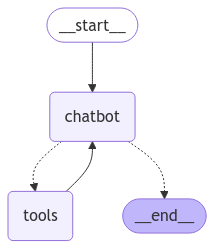

In [89]:
graph=graph_builder.compile()
graph

In [90]:
user_input="Hi there! , My name is Utkarsh"
events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! , My name is Utkarsh
================================== Ai Message ==================================

Nice to meet you, Utkarsh. Is there something I can help you with today?


In [91]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_rhk4)
 Call ID: call_rhk4
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_hw1z)
 Call ID: call_hw1z
  Args:
    query: RLHF training process
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine